Importing all the neccessary libraries

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import datetime
from datetime import date, timedelta
import fbprophet
from fbprophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error
from fbprophet.plot import add_changepoints_to_plot
from fbprophet.plot import plot_cross_validation_metric 
from fbprophet.diagnostics import performance_metrics
from fbprophet.diagnostics import cross_validation
plt.style.use('fivethirtyeight')

# **Dataset and Data Preprocessing**



Dataset we are using for prediction is taken from NYTimes github. They are updating county wise covis cases daily basis. Using their dataset we could give up-to-date prediction with latest data.

In [0]:
covid_df= pd.read_csv("https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv",index_col=[0], parse_dates=[0])

In [20]:
covid_df.shape

(98262, 5)

We could see that fips has missing values and also for our model we dont want the column. so we are dropping it from the dataframe.

In [21]:
covid_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 98262 entries, 2020-01-21 to 2020-04-28
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   county  98262 non-null  object 
 1   state   98262 non-null  object 
 2   fips    97083 non-null  float64
 3   cases   98262 non-null  int64  
 4   deaths  98262 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 4.5+ MB


In [0]:
covid_df= covid_df.drop(['fips'], axis=1)

In [23]:
 covid_df.head()

,county,state,cases,deaths
date,,,,
2020-01-21,Snohomish,Washington,1,0
2020-01-22,Snohomish,Washington,1,0
2020-01-23,Snohomish,Washington,1,0
2020-01-24,Cook,Illinois,1,0
2020-01-24,Snohomish,Washington,1,0


In [24]:

covid_df.describe()

,cases,deaths
count,98262.000000,98262.000000
mean,188.175805,8.113523
std,2228.540492,144.169073
min,0.000000,0.000000
25%,3.000000,0.000000
50%,9.000000,0.000000
75%,39.000000,1.000000
max,162348.000000,12067.000000


Below plot shows the distribution of COnfirmed and Death Cases in the US. We could see there is 7-10% of death in over all confirmed cases from the given data.

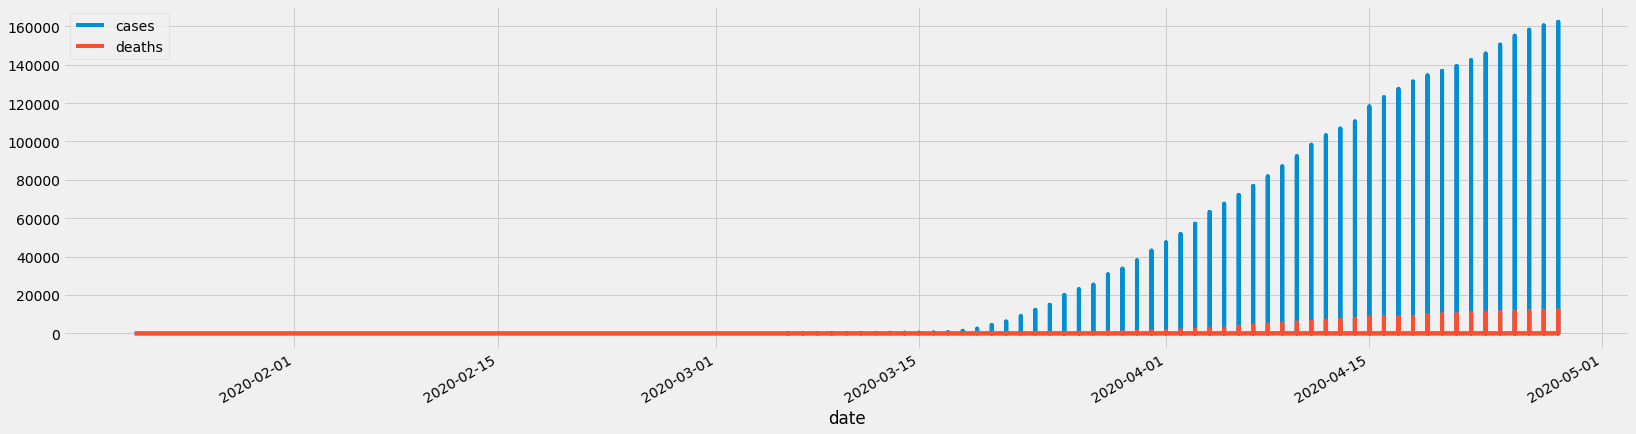

In [25]:
covid_df.plot(kind='line',figsize=(25,7))
plt.show()

Defining Color Codes to use in print statements.

In [0]:
class bcolors:
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'

# **PREDICTION**

Machine learning can be useful in various types of  predictions for Covid-19 like Identify who is most at risk, Diagnose patients, Develop drugs faster, Predict the spread, Virus DNA/RNA structure analysis etc. In our project we are designing a model to forecast the spread in USA county wise for next two weeks, to help people to know what they can expect in their region and prepare accordingly. So the forecasting model we are considering should be able to predict with good accuracy even for the small range of time series of data (corresponds to county level) and the model should be sensitive to minute trends and changes in spread data on a daily basis. With these requirements, we were considering forecasting models like ARIMA, LSTM and FBPROPHET. After a lot of research, we found FBPROPHET could be the best candidate to satisfy the requirement of predicting the forecast for county wise dataset. 

**Covid-19 Spread US - County Wise Forecast Prediction with FBPROPHET MODEL**

**FBPROPHET Implementation**

Prophet is an open source forecasting model that works on time series data using an additive model where the data set can be fit in the model on yearly, weekly, and daily basis with holiday effects. This makes the FBProphet model strong in forecasting trends which have any seasonal changes and effects with missing data and any shifts in the trend.





**Test-Train Split Validation**

  i) For the county wise prediction we did  training and test data split by 80:20 ratio. Data is split by the custom technique implemented in our code based on the available date range on county basis.

 ii) Model is tuned by passing weekly seasonality parameters to observe everyday trends in the data.

iii) Accuracy of the model is calculated based on the MAE and MAPE using SKLearn metrics and custom code.


In [0]:
from fbprophet.plot import plot_cross_validation_metric

#Below function to calculate MAPE error metric for the forecast
def mean_absolute_percentage_error(y_true, y_pred): 
  """Calculates MAPE given y_true and y_pred"""
  y_true, y_pred = np.array(y_true), np.array(y_pred)
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

'''
Below function is to fit the train data  and predict test data.

1. Changing the dataset format according to fbprophet model input.
2. Fitting the training data to the model
3. Predicting for the test data
4. Plotting the Trend 
5. Calculating Error Metrix
6. Forecasting for the next two weeks using the trained and tested model
7. Plotting the trend
'''
def fbprophet_fit_train_predict(train, test):
  print(bcolors.BOLD+"Formatting data for fbprophet model")
  print(bcolors.ENDC)
  print(train.reset_index() \
    .rename(columns={'date':'ds',
                     'Confirmed':'y'}).head())
  model = Prophet()
  model.add_seasonality(name="weekly",period=30.5,fourier_order=7)
  model.fit(train.reset_index() \
              .rename(columns={'date':'ds',
                               'Confirmed':'y'}))
  test_fcst = model.predict(df=test.reset_index() \
                                  .rename(columns={'date':'ds'}))
  plt.show()
  print(bcolors.BOLD+"Test Set Prediction Values and thresholds")
  print(bcolors.ENDC)
  print(test_fcst.head())
  print()
  print(bcolors.BOLD+"Test Set Prediction Trend")
  print(bcolors.ENDC)
  f, ax = plt.subplots(1)
  f.set_figheight(5)
  f.set_figwidth(15)
  fig = model.plot(test_fcst,
                 ax=ax)
  plt.show()
  print()
  print(bcolors.BOLD+"Test Set components Trend")
  print(bcolors.ENDC)
  fig = model.plot_components(test_fcst)
  plt.show()
  future_dates = model.make_future_dataframe(periods=30)
  prediction =  model.predict(future_dates)
  print(bcolors.BOLD+"Forecast for next two weeks")
  print(bcolors.ENDC)
  fig = model.plot(prediction)
  c = add_changepoints_to_plot(fig.gca(),model,prediction)
  plt.show()
  ''' Calculating ERROR Metrics for the Model '''
  print(bcolors.BOLD+"ERROR METRICS")
  print("MAE")
  print(mean_absolute_error(y_true=test['Confirmed'],
                   y_pred=test_fcst['yhat']))
  print("MAPE")
  print(mean_absolute_percentage_error(y_true=test['Confirmed'],
                   y_pred=test_fcst['yhat']))

In [0]:
'''
  Below function is to do train and test data split to use in the fbprohet model prediction
  We are doing county wise forecasting, so we need to split train and test according to the data range we have for each county. 
  1 . Custom Train and Test Split using daterange in dataset  (80 - 20%)
  2 . Plotting the Train and Test distribution
'''
def train_test_split(df, split_date):
  t = split_date.strftime('%Y-%m-%d')
  train = df.loc[df.index <= t].copy()
  test = df.loc[df.index > t].copy()
  print(bcolors.BOLD+"Train Data Description")
  print(bcolors.ENDC)
  print(train.describe())
  print()
  print(bcolors.BOLD + 'Train Test Split Trend' )
  test \
    .rename(columns={'Confirmed': 'TEST SET'}) \
    .join(train.rename(columns={'Confirmed': 'TRAINING SET'}),
          how='outer') \
    .plot(figsize=(30,7), title='Train Test Split')
  plt.show()
  fbprophet_fit_train_predict(train, test)
def findSplitPoint(df):
  print("first row date", df.index[0])
  start_date = (df.index[0]).date()
  cur_date = date.today()
  tol_days= cur_date - start_date
  print("total days", tol_days)
  days = tol_days*.2
  split_date=cur_date - days
  print("split_date",split_date)
  return split_date

**CROSS VALIDATION USING PROBHET'S DIAGNOSTICS**

i) Using FBProphet’s diagnostics module we could cross validate the model over different cutoff to predict given horizon with the initial parameter of the time series data. 

ii) Hyper tuned the change point parameter  of the algorithm using custom code. By tuning this parameter we could make the model to observe the change trends in the data in various intervals.

iii) Accuracy of the model is calculated using FbProphets performance metrics module. Error metrics considered to evaluate the model are MAE and MAPE.


In [0]:
'''
  Below is to implement time-series cross validation using cv function of FBProphet Diagnostics
  1. Hypertuning the model with different change_point_prior parameter
  2. Plotting the MAPE and the forecasting of model with different parameter
  3. Plotting the future forecast of the best model
'''
def cross_validate(df):
  fig, ax = plt.subplots(10,1, figsize = (14, 20))
  ax = ax.ravel()
  df=df.reset_index()
  df=df.rename(columns={'date':'ds','Confirmed':'y'})
  j = 0
  for i in [0.01, 0.05, 0.10, 0.15, 0.20]:
    m = Prophet(changepoint_prior_scale=i)
    #fit the prophet model on the data
    m.fit(df)
    # make a dataframe of the next 20 days 
    future = m.make_future_dataframe(periods=20)
    #predict on this future dataframe
    forecast = m.predict(future)
    print(forecast.head())
    # plot the forecast 
    print(bcolors.BOLD+"Forecast Prediction")
    fig = m.plot(forecast, ax = ax[j])
    ax[j].set_title('changepoint prior = ' + str(i))
    j += 1
    df_cv = cross_validation(m, initial='30 days', period='5 days', horizon = '20 days')
    fig = plot_cross_validation_metric(df_cv, metric='mape', ax = ax[j])
    ax[j].set_title(str(str(i) + ' Change Point Prior Mean Absolute Percentage Error'))
    ax[j].set_ylim(0,0.5)
    j += 1
  plt.show()
  print("final cv")
  print(df_cv.tail())
  result_df = forecast.reset_index()
  fig = px.line(result_df, x='ds', y='yhat')
  fig.update_traces(mode='lines')
  fig.show()
  df_p = performance_metrics(df_cv)
  print(bcolors.BOLD+"Performance and Error Metrics")
  print(bcolors.ENDC)
  print(df_p.head())
  fig = plot_cross_validation_metric(df_cv, metric='mape')
  plt.show()

In [0]:
'''
Below function is the primary function to inititate building the model for County wise forecasting
1. Filtering the dataset for the given state and country 
2. Renaming the columns 
3. Plotting the current trend of Confirmed and Death cases in the given county
4. FBProphet model need atleast 30 days of trend to do forecasting so filerting the counties with lesser trend
5. Invoking the Train Test Split Validation
6. Invoking the Time Series Cross validation

'''
def predictSpread(State, County):
  county_df = covid_df[(covid_df['state'] == State) & (covid_df['county'] == County)]
  county_df=county_df.drop(['county', 'state'], axis=1)
  county_df.columns = ['Confirmed', 'Deaths']
  print(bcolors.BOLD+"Data Description")
  print(bcolors.ENDC)
  print(county_df.head())
  print()
  print(bcolors.BOLD+" Current Spread Trend in the", County , "county, ",State)
  plt.figure(figsize=(23,10))
  plt.bar(county_df.index, county_df.Confirmed,label="Confirm Cases")
  plt.bar(county_df.index, county_df.Deaths,label="Deaths")
  plt.xlabel('Date')
  plt.ylabel("Count")
  plt.legend(frameon=True, fontsize=12)
  plt.title('Confirmed vs Deaths',fontsize = 35)
  plt.show()
  county_df.plot(kind='line',figsize=(25,7))
  plt.show()
  if len(county_df.index) < 30:
    print(bcolors.OKBLUE+" Too less data to forsee the forecast or The ",County, " County is very good at Social Distancing ")
    return
  county_df=county_df.drop(['Deaths'], axis=1)
  print(bcolors.BOLD+"Test Train Split Validation with FBProphet")
  print()
  print(bcolors.ENDC)
  split_date = findSplitPoint(county_df)
  train_test_split(county_df, split_date)
  print(bcolors.BOLD+"Cross Validation with FBProphet")
  print()
  print(bcolors.ENDC)
  cross_validate(county_df)

**ENTER STATE AND COUNTY TO SEE THE FORECAST**

Data Description

            Confirmed  Deaths
date                         
2020-01-31          1       0
2020-02-01          1       0
2020-02-02          2       0
2020-02-03          2       0
2020-02-04          2       0

 Current Spread Trend in the Santa Clara county,  California


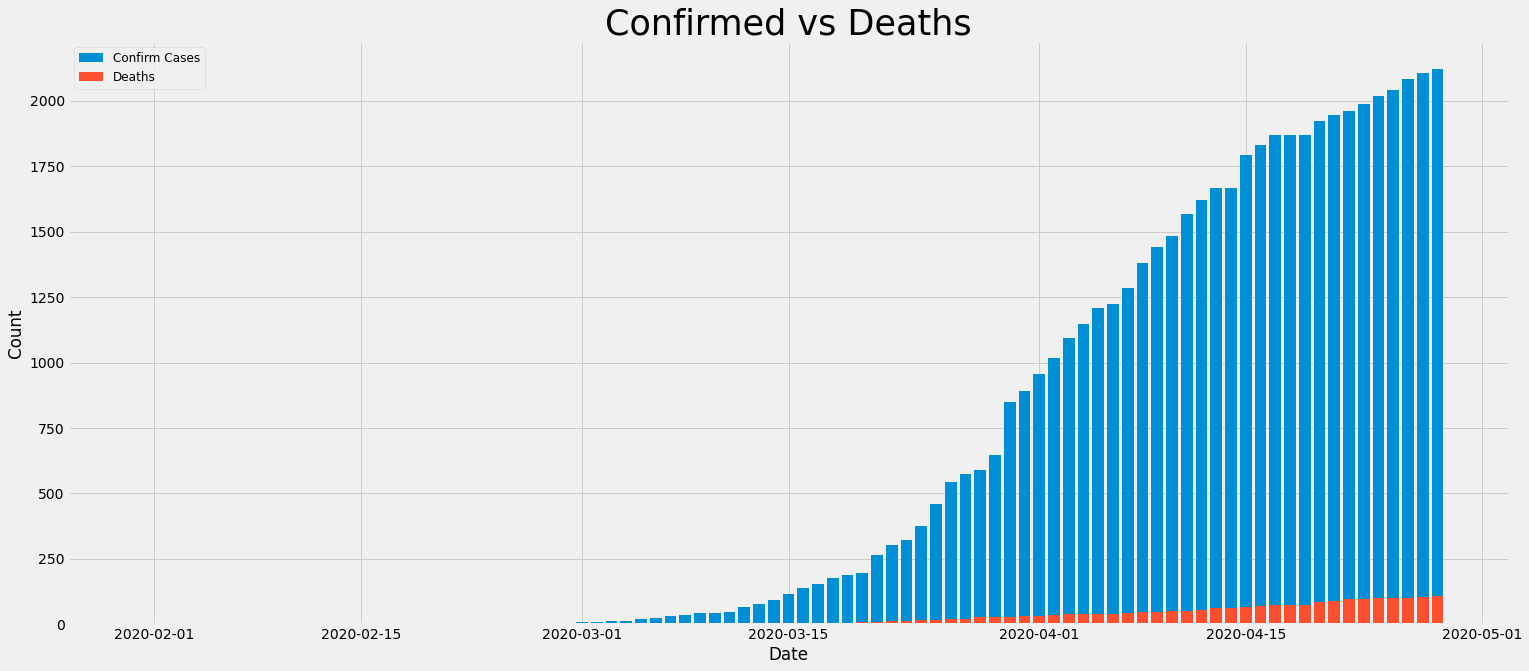

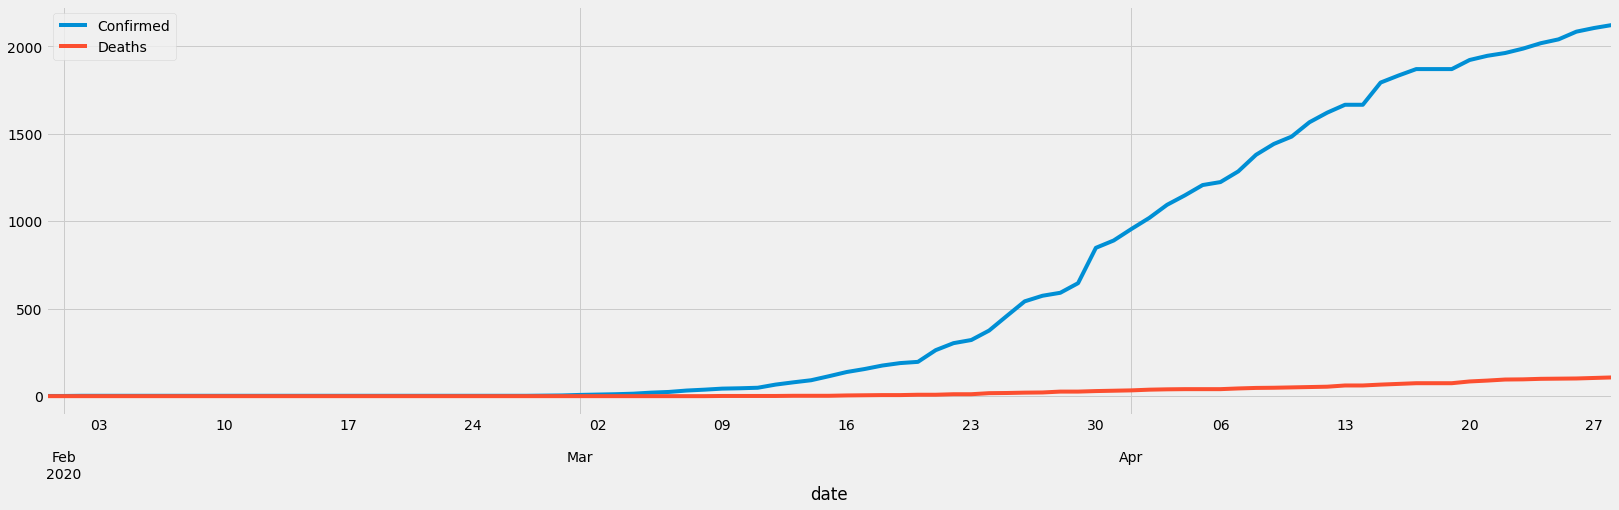

Test Train Split Validation with FBProphet


first row date 2020-01-31 00:00:00
total days 89 days, 0:00:00
split_date 2020-04-12
Train Data Description

         Confirmed
count    73.000000
mean    312.219178
std     484.902632
min       1.000000
25%       2.000000
50%      32.000000
75%     459.000000
max    1621.000000

Train Test Split Trend


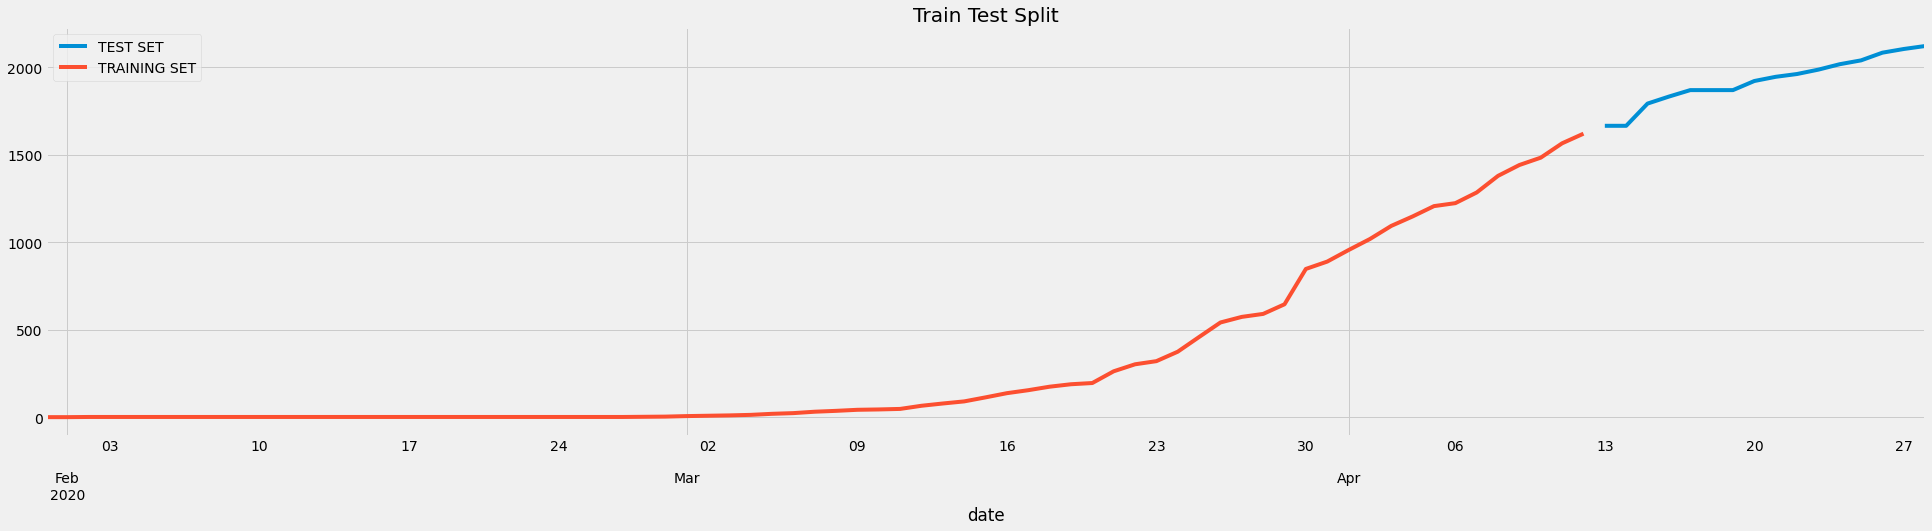

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Formatting data for fbprophet model

          ds  y
0 2020-01-31  1
1 2020-02-01  1
2 2020-02-02  2
3 2020-02-03  2
4 2020-02-04  2
Test Set Prediction Values and thresholds

          ds        trend  ...  multiplicative_terms_upper         yhat
0 2020-04-13  1694.937289  ...                         0.0  1694.182360
1 2020-04-14  1759.570419  ...                         0.0  1754.382206
2 2020-04-15  1824.203548  ...                         0.0  1821.797326
3 2020-04-16  1888.836677  ...                         0.0  1894.986021
4 2020-04-17  1953.469806  ...                         0.0  1958.410061

[5 rows x 16 columns]

Test Set Prediction Trend



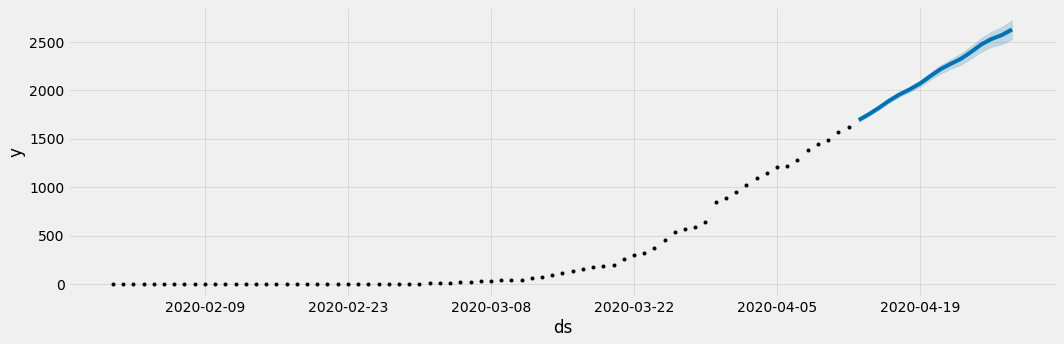


Test Set components Trend



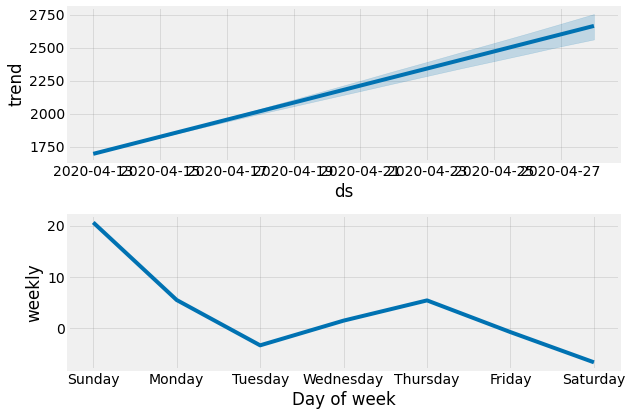

Forecast for next two weeks



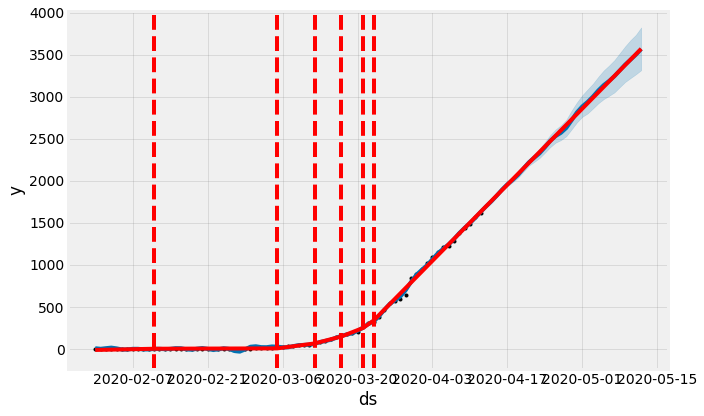

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


ERROR METRICS
MAE
250.82138703031345
MAPE
12.556403487901438
Cross Validation with FBProphet


          ds       trend  ...  multiplicative_terms_upper        yhat
0 2020-01-31 -566.038278  ...                         0.0 -548.834164
1 2020-02-01 -539.523494  ...                         0.0 -528.607918
2 2020-02-02 -513.008711  ...                         0.0 -506.687381
3 2020-02-03 -486.493927  ...                         0.0 -476.911491
4 2020-02-04 -459.979143  ...                         0.0 -460.073829

[5 rows x 16 columns]
Forecast Prediction


INFO:fbprophet:Making 8 forecasts with cutoffs between 2020-03-04 00:00:00 and 2020-04-08 00:00:00
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 8 forecasts with cutoffs between 2020-03-04 00:00:00 and 2020-04-08 00:00:00


          ds     trend  ...  multiplicative_terms_upper      yhat
0 2020-01-31 -1.170691  ...                         0.0 -0.352412
1 2020-02-01 -0.951818  ...                         0.0 -2.458621
2 2020-02-02 -0.732945  ...                         0.0 -5.169930
3 2020-02-03 -0.514072  ...                         0.0 -0.035087
4 2020-02-04 -0.295199  ...                         0.0 -7.826517

[5 rows x 16 columns]
Forecast Prediction


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 8 forecasts with cutoffs between 2020-03-04 00:00:00 and 2020-04-08 00:00:00


          ds     trend  ...  multiplicative_terms_upper      yhat
0 2020-01-31  0.903084  ...                         0.0  0.718893
1 2020-02-01  0.985512  ...                         0.0 -2.603490
2 2020-02-02  1.067939  ...                         0.0 -4.238123
3 2020-02-03  1.150366  ...                         0.0  1.973398
4 2020-02-04  1.232793  ...                         0.0 -4.740907

[5 rows x 16 columns]
Forecast Prediction


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 8 forecasts with cutoffs between 2020-03-04 00:00:00 and 2020-04-08 00:00:00


          ds     trend  ...  multiplicative_terms_upper      yhat
0 2020-01-31  1.260694  ...                         0.0  1.493399
1 2020-02-01  1.322440  ...                         0.0 -1.649324
2 2020-02-02  1.384186  ...                         0.0 -3.682692
3 2020-02-03  1.445932  ...                         0.0  2.130094
4 2020-02-04  1.507678  ...                         0.0 -4.981187

[5 rows x 16 columns]
Forecast Prediction


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 8 forecasts with cutoffs between 2020-03-04 00:00:00 and 2020-04-08 00:00:00


          ds     trend  ...  multiplicative_terms_upper      yhat
0 2020-01-31  1.517598  ...                         0.0  1.778426
1 2020-02-01  1.563032  ...                         0.0 -1.375245
2 2020-02-02  1.608466  ...                         0.0 -3.440421
3 2020-02-03  1.653900  ...                         0.0  2.340558
4 2020-02-04  1.699334  ...                         0.0 -4.802988

[5 rows x 16 columns]
Forecast Prediction


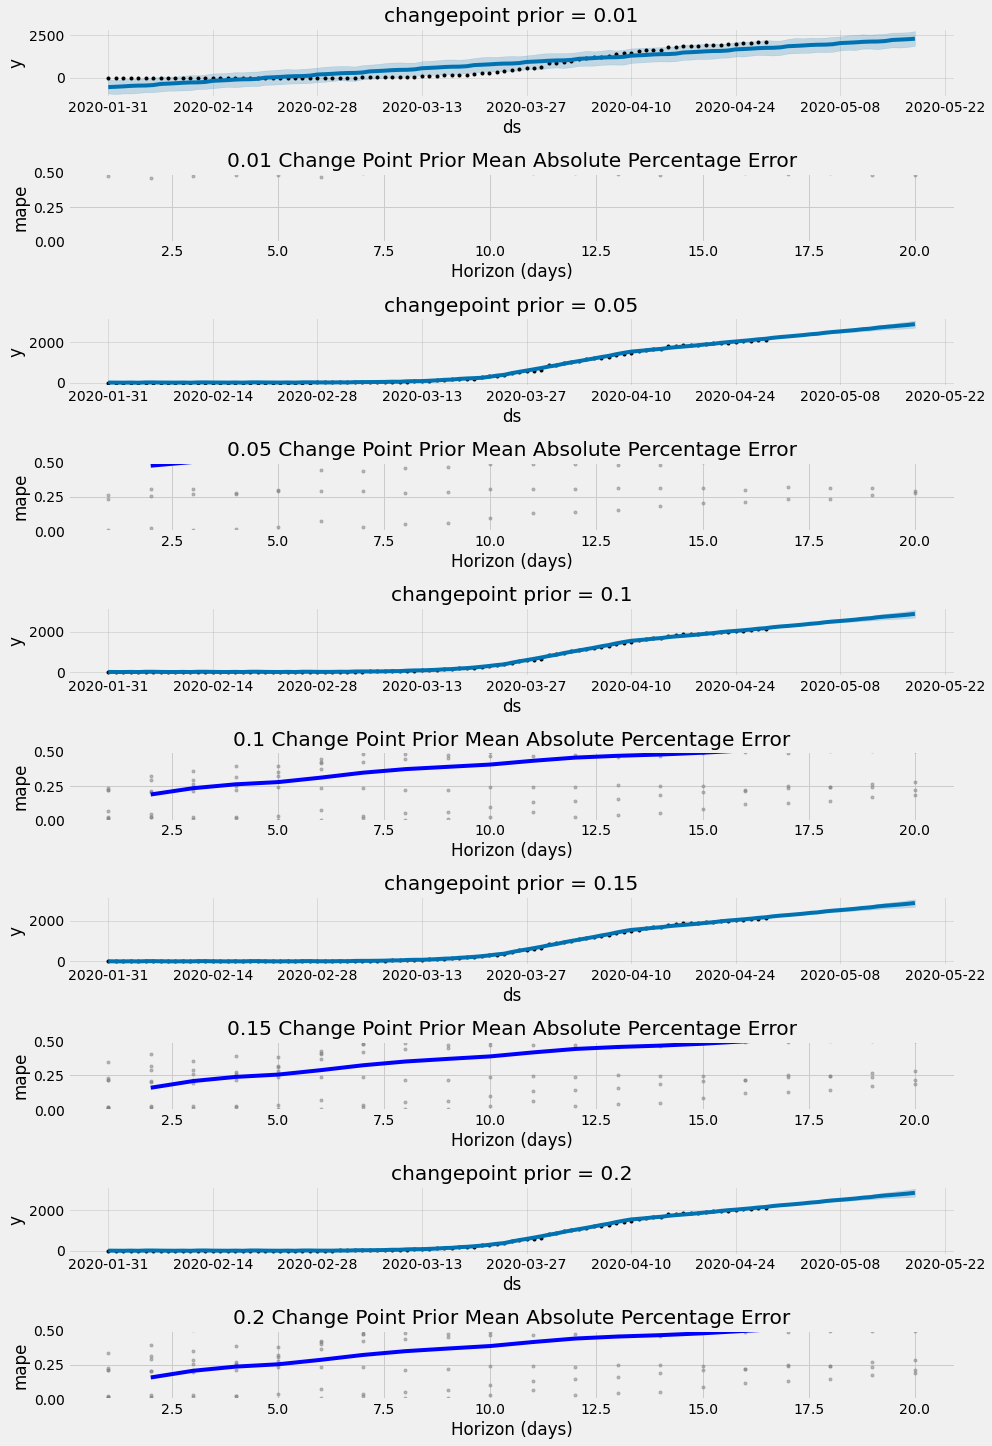

final cv
            ds         yhat   yhat_lower   yhat_upper     y     cutoff
155 2020-04-24  2462.544776  2354.399514  2562.028589  2018 2020-04-08
156 2020-04-25  2526.021743  2402.685291  2636.320460  2040 2020-04-08
157 2020-04-26  2592.196429  2468.707842  2701.752741  2084 2020-04-08
158 2020-04-27  2666.669254  2524.624152  2792.560151  2105 2020-04-08
159 2020-04-28  2728.987093  2576.132836  2865.940137  2122 2020-04-08


Performance and Error Metrics

  horizon           mse        rmse         mae      mape     mdape  coverage
0  2 days   6803.986899   82.486283   54.697449  0.158043  0.204289    0.3750
1  3 days   8934.649760   94.523276   68.388168  0.206603  0.208793    0.1875
2  4 days  10287.587851  101.427747   75.910662  0.236623  0.250909    0.0625
3  5 days  13100.072884  114.455550   86.332992  0.253439  0.264074    0.0625
4  6 days  24044.352265  155.062414  115.647241  0.285519  0.314134    0.1250


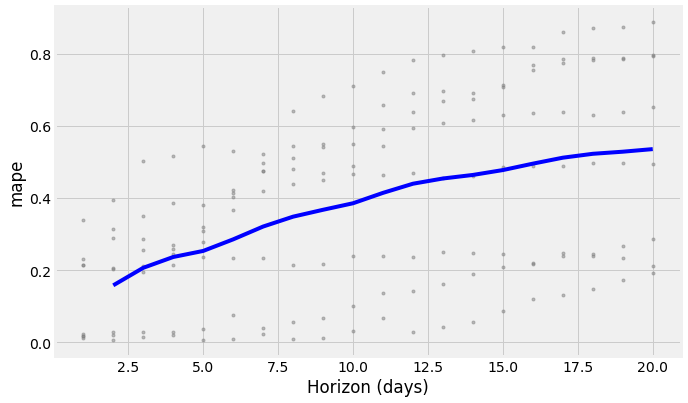

In [31]:
predictSpread("California","Santa Clara")


Data Description

            Confirmed  Deaths
date                         
2020-04-19          1       0
2020-04-20          1       0
2020-04-21          1       0
2020-04-22          1       0
2020-04-23          4       0

 Current Spread Trend in the Houston county,  Texas


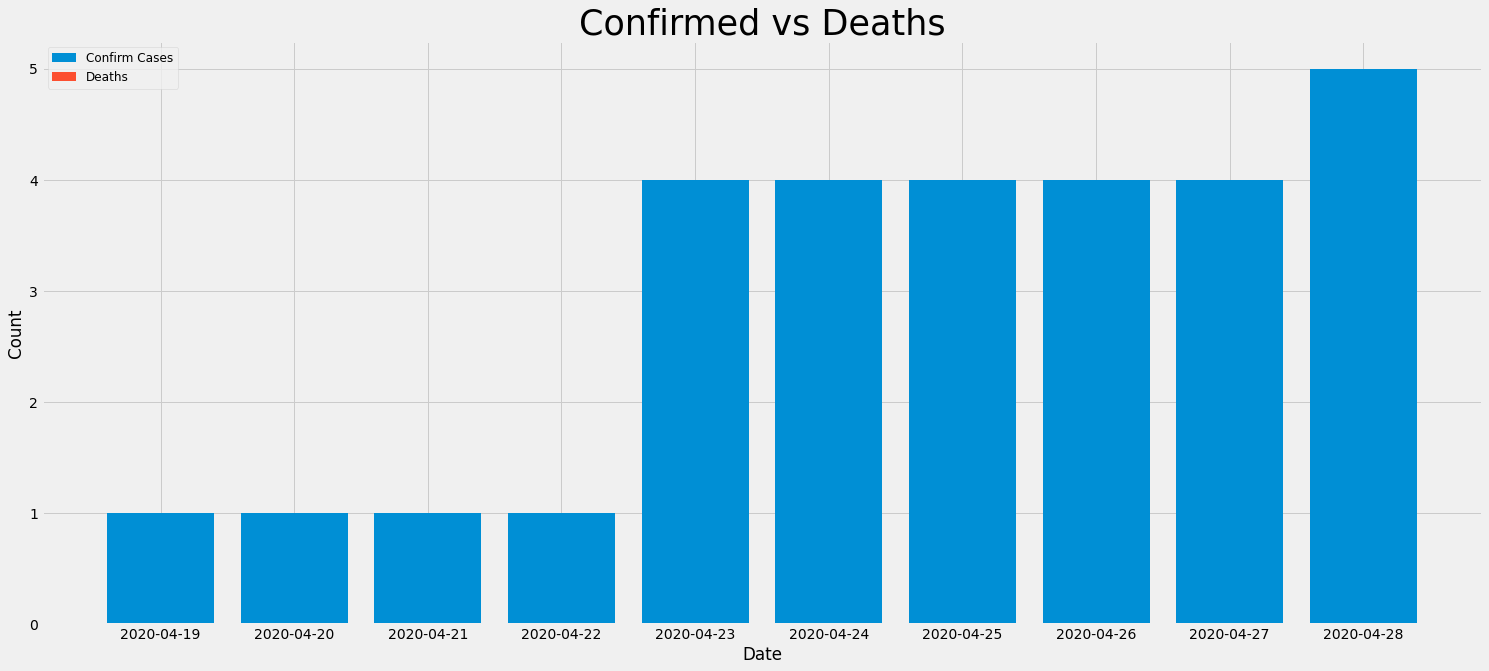

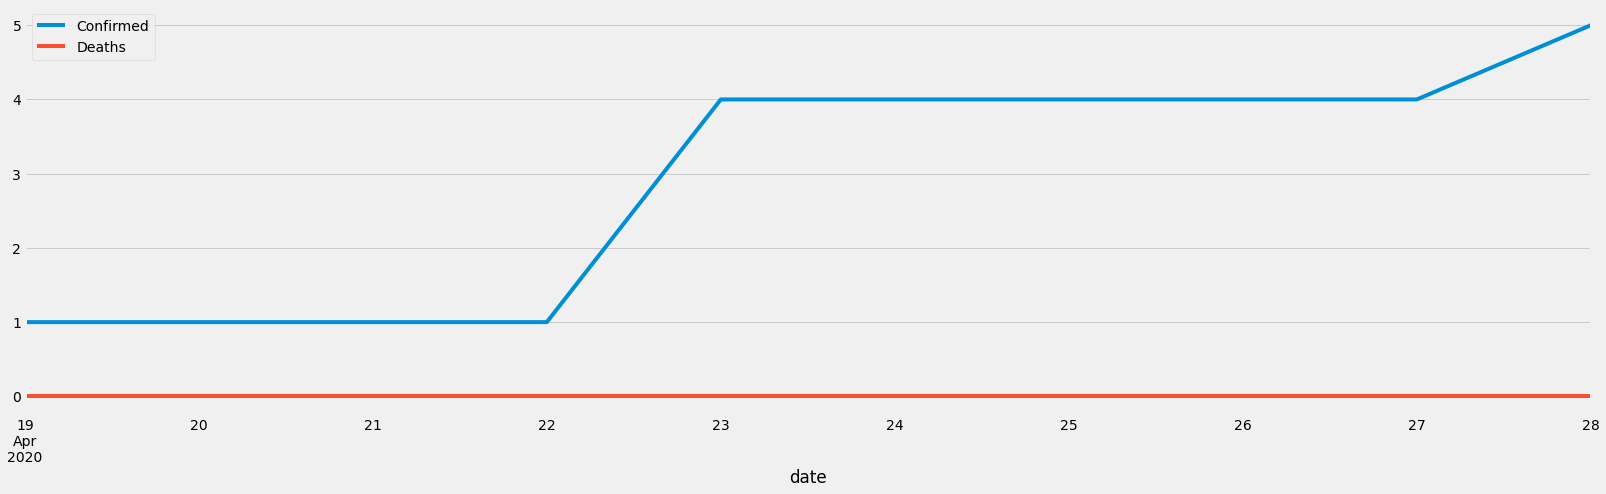

 Too less data to forsee the forecast or The  Houston  County is very good at Social Distancing 


In [32]:
predictSpread("Texas","Houston")

# **Compare ForeCasting of Top 5 US Hotspot Counties Today**

In [0]:
'''
Below function is to implement the comparison analysis of top 5 hotspot counties
1. Predicting for each county using best parameter found in the cross validation
2. Appending the prediction the result dataframe to plot the comparison chart
'''
def predictCompare(state, county):
  county_df = covid_df[(covid_df['state'] == state) & (covid_df['county'] == county)]
  df = covid_df[(covid_df['state'] == state) & (covid_df['county'] == county)]
  county_df=county_df.drop(['county', 'state'], axis=1)
  county_df.columns = ['Confirmed', 'Deaths']
  county_df=county_df.drop(['Deaths'], axis=1)
  print(bcolors.BOLD+" Forecasting with FBProphet")
  print()
  print(bcolors.ENDC)
  county_df=county_df.reset_index()
  county_df=county_df.rename(columns={'date':'ds','Confirmed':'y'})
  m = Prophet(changepoint_prior_scale=0.05)
  m.fit(county_df)
  future = m.make_future_dataframe(periods=20)
  forecast = m.predict(future)
  forecast = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
  forecast['state'] = state
  forecast['county'] = county
  county_df.set_index('ds', inplace=True)
  forecast.set_index('ds', inplace=True)
  #forecast = df.join(forecast[['yhat', 'yhat_lower','yhat_upper']], how = 'outer')
  return forecast


In [34]:
'''
  Below function is to forecast the top 5 US hotspot counties/ top 5 State wise hotspot counties and
  plotting the trend to provide comparison analysis

  1. Filtering the Dataset as per the input (US / State level)
  2. Obtaining the Top 5 Counties with maximum confirmed cases 
  3. Plotting the current trend of all the counties in a chart for comparison analysis
  4. Forecasting for all the counties individually using FBprophet
  5. Plotting the forecast comparison of upper, lower and trend results of FBProphet
'''
def hotSpot_trend_comparison(state):
  covid_county_latest_df = covid_df.groupby('county')['state','cases', 'deaths'].max().reset_index()
  loc = "US"
  if state:
    covid_county_latest_df = covid_county_latest_df[(covid_county_latest_df['state'] == state)]
    loc = state
  hotspot_df = covid_county_latest_df.nlargest(5,"cases")
  result_df = pd.DataFrame()
  print()
  print(bcolors.BOLD+" Top 5", loc," HotSpot Counties Today")
  fig = go.Figure(data=[go.Table(
    header=dict(values=list(hotspot_df.columns),
                fill_color='paleturquoise',
                align='left'),
    cells=dict(values=[hotspot_df.county, hotspot_df.state, hotspot_df.cases, hotspot_df.deaths],
               fill_color='lavender',
               align='left'))
    ])

  fig.show()
  for index, row in hotspot_df.iterrows():
    result = predictCompare(row['state'], row['county'])
    result_df = result_df.append(result)
  #start_remove = pd.to_datetime('2020-04-16')
  #result_df = result_df.query('index > @start_remove')
  #result_df = result_df.loc[(result_df.index < start_remove)]
  #result_df= result_df[(result_df['Delivery Date'].dt.year == 1970) | (df['Delivery Date'] >= sixmonthago)]
  print()
  print(bcolors.BOLD+" Next Two Weeks Forecast in Top 5", loc ," HotSpot Counties ")
  print()
  print(bcolors.BOLD+"Comparison of Forecast Trend in top 5 hoptspot  counties")
  result_df = result_df.reset_index()
  fig = px.line(result_df, x='ds', y='yhat', color='county')
  fig.update_traces(mode='lines')
  fig.show()
  print()
  print(bcolors.BOLD+"Comparison of Lower Forecast Trend in top 5 hoptspot  counties")
  fig = px.line(result_df, x='ds', y='yhat_lower', color='county')
  fig.update_traces(mode='lines')
  fig.show()
  print()
  print(bcolors.BOLD+"Comparison of Lower Forecast Trend in top 5 hoptspot  counties")
  fig = px.line(result_df, x='ds', y='yhat_upper', color='county')
  fig.update_traces(mode='lines')
  fig.show()
hotSpot_trend_comparison(None)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.




 Top 5 US  HotSpot Counties Today


 Forecasting with FBProphet




INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


 Forecasting with FBProphet




INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


 Forecasting with FBProphet




INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


 Forecasting with FBProphet




INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


 Forecasting with FBProphet



 Next Two Weeks Forecast in Top 5 US  HotSpot Counties 

Comparison of Forecast Trend in top 5 hoptspot  counties



Comparison of Lower Forecast Trend in top 5 hoptspot  counties



Comparison of Lower Forecast Trend in top 5 hoptspot  counties


In [35]:
hotSpot_trend_comparison("California")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.




 Top 5 California  HotSpot Counties Today


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


 Forecasting with FBProphet




INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


 Forecasting with FBProphet




INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


 Forecasting with FBProphet




INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


 Forecasting with FBProphet




INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


 Forecasting with FBProphet



 Next Two Weeks Forecast in Top 5 California  HotSpot Counties 

Comparison of Forecast Trend in top 5 hoptspot  counties



Comparison of Lower Forecast Trend in top 5 hoptspot  counties



Comparison of Lower Forecast Trend in top 5 hoptspot  counties
